---
---
### Deep Learning Practice (series 1)
##### Mostafa Shahbazi Dill - id: 40252521602
##### 2024-March-01
---
---

#### Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import madgrad
import matplotlib.pyplot as plt

---
---
### 1. Dataset Details

In [2]:
# Define transform to convert images to tensors
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Compute the number of input nodes
input_nodes = 28 * 28  # MNIST images are 28x28 pixels

# Compute the number of output nodes
output_nodes = 10  # Since there are 10 classes (digits 0-9)

---
### 1.1
##### MLP model with two hidden layers

In [27]:
class MLP(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size,
        dropout_rate,
        activation,
    ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images

        # x = torch.relu(self.fc1(x)) # default activation function
        x = self.activation(self.fc1(x))
        x = self.dropout(x)

        x = self.activation(self.fc2(x))
        # x = torch.relu(self.fc2(x)) # default activation function
        x = self.dropout(x)
        x = self.fc3(x)

        return x

---
### 1.2
##### training loop and evaluation function

In [4]:
def train(model, criterion, optimizer, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    # print(f"Accuracy on test set: {accuracy}")
    return accuracy

---
---
#### 2.1
##### optimization methods: SGD, Adam, RMSprop, MADGRAD (paper), mirrorMADGRAD (paper)

In [ ]:
# Define the model, loss function, and optimization methods
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
criterion = nn.CrossEntropyLoss()

# Train with SGD optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)
train(model, criterion, optimizer_sgd, train_loader, epochs=5)
accuracy_sgd = evaluate(model, test_loader)

# Train with Adam optimizer
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
train(model, criterion, optimizer_adam, train_loader, epochs=5)
accuracy_adam = evaluate(model, test_loader)

# Train with RMSprop optimizer
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001)
train(model, criterion, optimizer_rmsprop, train_loader, epochs=5)
accuracy_rmsprop = evaluate(model, test_loader)

# Train with MADGRAD optimizer (our new optimizer according to the paper)
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_madgrad = madgrad.MADGRAD(
    params=model.parameters(), decouple_decay=True, lr=0.001
)
train(model, criterion, optimizer_madgrad, train_loader, epochs=5)
accuracy_madgrad = evaluate(model, test_loader)

# Train with MirrorMADGRAD optimizer
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.5,
    activation=torch.relu,
)
optimizer_mirrormadgrad = madgrad.MirrorMADGRAD(
    params=model.parameters(), decouple_decay=True, lr=0.001
)
train(model, criterion, optimizer_mirrormadgrad, train_loader, epochs=5)
accuracy_mirrormadgrad = evaluate(model, test_loader)


print(f">>(SGD)<<Accuracy: {accuracy_sgd}")
print(f">>(Adam)<<Accuracy: {accuracy_adam}")
print(f">>(RMSprop)<<Accuracy: {accuracy_rmsprop}")
print(f">>(MADGRAD - paper op)<<Accuracy: {accuracy_madgrad}")
print(f">>(MirrorMADGRAD - paper op)<<Accuracy: {accuracy_mirrormadgrad}")

---
---
### 3.1
##### evaluate with different activation functions

##### activation functions: ReLU, Sigmoid, Softmax

In [ ]:
# Define activation functions
activations = [torch.relu, torch.sigmoid, torch.tanh]

# Evaluate the model with different activation functions
for activation in activations:
    model = MLP(
        input_nodes, 128, 64, output_nodes, dropout_rate=0.5, activation=activation
    )

    optimizer = madgrad.MADGRAD(params=model.parameters(), lr=0.001)
    train(model, criterion, optimizer, train_loader, epochs=5)
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy with activation {activation.__name__}: {accuracy}")

print(f"\nOptimizer: {optimizer.__class__.__name__}")

---
---
## 4.1
#### Dropout rates: 0.1, 0.3, 0.5, 0.7, 0.9

In [ ]:
dropout_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
for dropout_rate in dropout_rates:
    model = MLP(
        input_size=input_nodes,
        hidden_size1=128,
        hidden_size2=64,
        output_size=output_nodes,
        dropout_rate=dropout_rate,
        activation=torch.sigmoid,
    )

    optimizer = madgrad.MADGRAD(params=model.parameters(), lr=0.001)
    train(model, criterion, optimizer, train_loader, epochs=5)
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy with dropout rate {dropout_rate}: {accuracy}")

print(f"\nOptimizer: {optimizer.__class__.__name__}")

---
---
### 5.1
#### Data Augmentation

In [ ]:
# Augmentation transforms
augmentation_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Augmented dataset
augmented_train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=augmentation_transform, download=True
)
augmented_train_loader = DataLoader(
    augmented_train_dataset, batch_size=64, shuffle=True
)

# Evaluate the model with augmented data
model = MLP(
    input_size=input_nodes,
    hidden_size1=128,
    hidden_size2=64,
    output_size=output_nodes,
    dropout_rate=0.1,
    activation=torch.sigmoid,
)
optimizer = madgrad.MirrorMADGRAD(params=model.parameters(), lr=0.001)
# optimizer = optim.Adam(params=model.parameters(), lr=0.001)
train(model, criterion, optimizer, augmented_train_loader, epochs=5)
accuracy_augmented = evaluate(model, test_loader)
print(f"Accuracy with data augmentation: {accuracy_augmented}")

## 6.1
#### Batch Normalization

In [37]:
def train_plt(model, criterion, optimizer, train_loader, epochs, batch_size):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        # for i, (inputs, labels) in enumerate(train_loader, 1):
        #     optimizer.zero_grad()
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        #     loss.backward()
        #     optimizer.step()
        #     running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
        #     if i % 100 == 0:
        #         print(
        #             f"Epoch {epoch+1}, Batch {i}, Loss: {running_loss/(i*batch_size)}"
        #         )

        for i, data in enumerate(train_loader, 0):

            # Get inputs
            inputs, targets = data

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 0:
                print("Loss after mini-batch %5d: %.3f" % (i + 1, running_loss / 100))
                running_loss = 0.0

        epoch_loss = running_loss / len(
            train_loader.dataset
        )  # Divide by total number of samples
        losses.append(epoch_loss)
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


class MlpBatch(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size,
        dropout_rate,
        activation,
    ):
        super(MlpBatch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images

        # x = torch.relu(self.fc1(x)) # default activation function
        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        # x = torch.relu(self.fc2(x)) # default activation function
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x


Training with batch size: 16
Loss after mini-batch     1: 0.025
Loss after mini-batch   101: 0.910
Loss after mini-batch   201: 0.534
Loss after mini-batch   301: 0.537
Loss after mini-batch   401: 0.463
Loss after mini-batch   501: 0.423
Loss after mini-batch   601: 0.435
Loss after mini-batch   701: 0.429
Loss after mini-batch   801: 0.388
Loss after mini-batch   901: 0.382
Loss after mini-batch  1001: 0.333
Loss after mini-batch  1101: 0.313
Loss after mini-batch  1201: 0.350
Loss after mini-batch  1301: 0.333
Loss after mini-batch  1401: 0.347
Loss after mini-batch  1501: 0.339
Loss after mini-batch  1601: 0.346
Loss after mini-batch  1701: 0.276
Loss after mini-batch  1801: 0.338
Loss after mini-batch  1901: 0.303
Loss after mini-batch  2001: 0.342
Loss after mini-batch  2101: 0.327
Loss after mini-batch  2201: 0.327
Loss after mini-batch  2301: 0.302
Loss after mini-batch  2401: 0.288
Loss after mini-batch  2501: 0.287
Loss after mini-batch  2601: 0.288
Loss after mini-batch  27

Loss after mini-batch  2201: 0.268
Loss after mini-batch  2301: 0.251
Loss after mini-batch  2401: 0.311
Loss after mini-batch  2501: 0.251
Loss after mini-batch  2601: 0.242
Loss after mini-batch  2701: 0.249
Loss after mini-batch  2801: 0.288
Loss after mini-batch  2901: 0.250
Loss after mini-batch  3001: 0.215
Loss after mini-batch  3101: 0.252
Loss after mini-batch  3201: 0.274
Loss after mini-batch  3301: 0.225
Loss after mini-batch  3401: 0.263
Loss after mini-batch  3501: 0.244
Loss after mini-batch  3601: 0.267
Loss after mini-batch  3701: 0.231
Loss after mini-batch     1: 0.001
Loss after mini-batch   101: 0.203
Loss after mini-batch   201: 0.208
Loss after mini-batch   301: 0.223
Loss after mini-batch   401: 0.197
Loss after mini-batch   501: 0.222
Loss after mini-batch   601: 0.180
Loss after mini-batch   701: 0.230
Loss after mini-batch   801: 0.214
Loss after mini-batch   901: 0.213
Loss after mini-batch  1001: 0.248
Loss after mini-batch  1101: 0.212
Loss after mini-batc

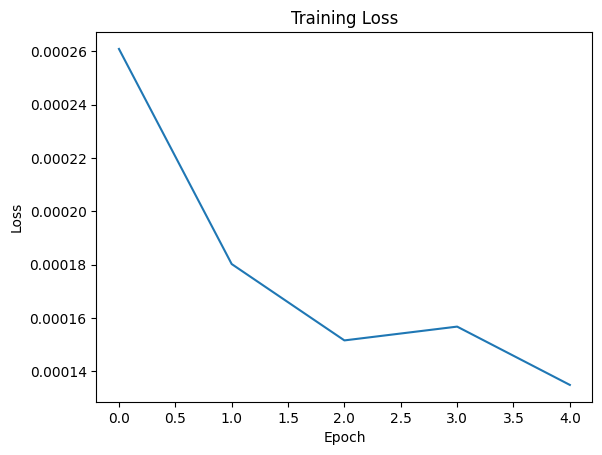

Accuracy with batch size 16: 0.9577


In [38]:
# Define batch sizes to test
batch_sizes = [16, 128]
batch_sizes = [16]
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = MlpBatch(
        input_size=input_nodes,
        hidden_size1=128,
        hidden_size2=64,
        output_size=output_nodes,
        dropout_rate=0.1,
        activation=torch.sigmoid,
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # train(model, criterion, optimizer, train_loader, epochs=5)
    train_plt(model, criterion, optimizer, train_loader, epochs=5, batch_size=16)
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy with batch size {batch_size}: {accuracy}")